1) Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

2) Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)

3) Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [3]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=42, test_size=0.3)

In [5]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [6]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
6252,0,1
4684,0,1
1731,1,0


In [8]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

In [9]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [10]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

In [11]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [12]:
#наши прогнозы для тестовой выборки
preds_rf = pipeline.predict_proba(X_test)[:, 1]
preds_rf[:10]

array([0.07, 0.02, 0.27, 0.15, 0.12, 0.01, 0.11, 0.34, 0.43, 0.32])

In [13]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report,\
precision_recall_curve, confusion_matrix

In [14]:
model_metrics = {
    'model': [], 
    'F-Score': [],
    'Precision': [],
    'Recall': [],
    'Threshold': []
}

In [15]:
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, preds_rf)

fscore_rf = (2 * precision_rf * recall_rf) / (precision_rf + recall_rf)
# locate the index of the largest f score
ix_rf = np.argmax(fscore_rf)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_rf[ix_rf], 
                                                                        fscore_rf[ix_rf],
                                                                        precision_rf[ix_rf],
                                                                        recall_rf[ix_rf]))

Best Threshold=0.410000, F-Score=0.609, Precision=0.681, Recall=0.551


In [16]:
model_metrics['model'].append('RandomForestClassifieer')
model_metrics['F-Score'].append(fscore_rf[ix_rf])
model_metrics['Precision'].append(precision_rf[ix_rf])
model_metrics['Recall'].append(recall_rf[ix_rf])
model_metrics['Threshold'].append(recall_rf[ix_rf])

In [17]:
from xgboost import XGBClassifier

In [18]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', XGBClassifier(random_state = 42)),
])

In [19]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [20]:
preds_xgb = pipeline.predict_proba(X_test)[:, 1]
preds_xgb[:10]

array([0.03150831, 0.01458976, 0.11885554, 0.09358115, 0.1405402 ,
       0.00666868, 0.13230424, 0.15500759, 0.19382975, 0.3552141 ],
      dtype=float32)

In [21]:
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_test, preds_xgb)

fscore_xgb = (2 * precision_xgb * recall_xgb) / (precision_xgb + recall_xgb)
# locate the index of the largest f score
ix_xgb = np.argmax(fscore_xgb)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_xgb[ix_xgb], 
                                                                        fscore_xgb[ix_xgb],
                                                                        precision_xgb[ix_xgb],
                                                                        recall_xgb[ix_xgb]))

Best Threshold=0.434967, F-Score=0.604, Precision=0.686, Recall=0.539


In [22]:
model_metrics['model'].append('XGBClassifier')
model_metrics['F-Score'].append(fscore_xgb[ix_xgb])
model_metrics['Precision'].append(precision_xgb[ix_xgb])
model_metrics['Recall'].append(recall_xgb[ix_xgb])
model_metrics['Threshold'].append(thresholds_xgb[ix_xgb])

In [23]:
pipeline = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

In [24]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [25]:
preds_lr = pipeline.predict(X_test)
preds_lr

array([0, 0, 0, ..., 0, 0, 0])

In [26]:
from sklearn.metrics import f1_score, recall_score, precision_score

In [27]:
recall = recall_score(y_test, preds_lr)
recall

0.2089041095890411

In [28]:
precision = precision_score(y_test, preds_lr)
precision

0.5727699530516432

In [29]:
f_score = f1_score(y_test, preds_lr)
f_score

0.30614805520702637

In [30]:
model_metrics['model'].append('LogisticRegression')
model_metrics['F-Score'].append(f_score)
model_metrics['Precision'].append(precision)
model_metrics['Recall'].append(recall)
model_metrics['Threshold'].append(0)

In [31]:
models_df = pd.DataFrame(model_metrics)
models_df.iloc[:,1:] = models_df.iloc[:,1:].apply(lambda x: round(x,2))
models_df

,model,F-Score,Precision,Recall,Threshold
0,RandomForestClassifieer,0.61,0.68,0.55,0.55
1,XGBClassifier,0.60,0.69,0.54,0.43
2,LogisticRegression,0.31,0.57,0.21,0.00


Модели RandomForestClassifier и XGBClassifier равны между собой. В зависимости от задачи, Precision или Recall могут быть более или менее важными. Возьмем XGB Classifier для дальнейшего разбора задания.  

In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[2272  144]
 [ 270  314]]


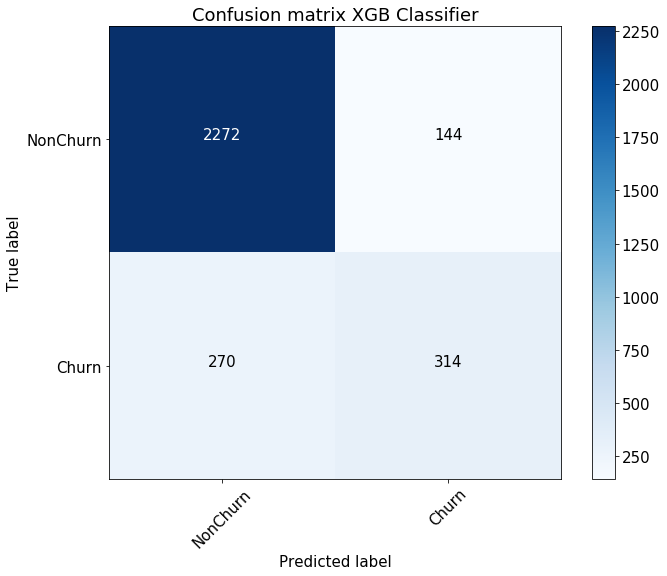

In [33]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_xgb>thresholds_xgb[ix_xgb])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix XGB Classifier')
plt.savefig("conf_matrix.png")
plt.show()

Если прибыль с каждого True Positive 2 доллара, а стоимость удержания 1 доллар, то потенциальный доход от такой рекламной кампании можно вычислить по формуле: TP * 2 - (TP + FP) * 1

In [34]:
2*2272 - (2272+144)

2128

Наша прогнозируемая прибыль $2128